<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 31.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.3
    Uninstalling widgetsnbextension-3.6.3:
      Successfull

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-03-24 11:40:51--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-03-24 11:40:51--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  85.5MB/s    in 5.0s    

2023-03-24 11:40:56 (90.7 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [ ]:
import os
import math

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)[:100]):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)
        
              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X[split].append(voxel_grid)
            Y[split].append(label1)
            Z[split].append(label2)

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'test'
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)[:50]):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)

              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X[split].append(voxel_grid)
            Y[split].append(label1)
            Z[split].append(label2)


100%|██████████| 50/50 [00:01<00:00, 25.77it/s]


In [4]:
import os
import math
import random

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:03<00:00, 28.52it/s]


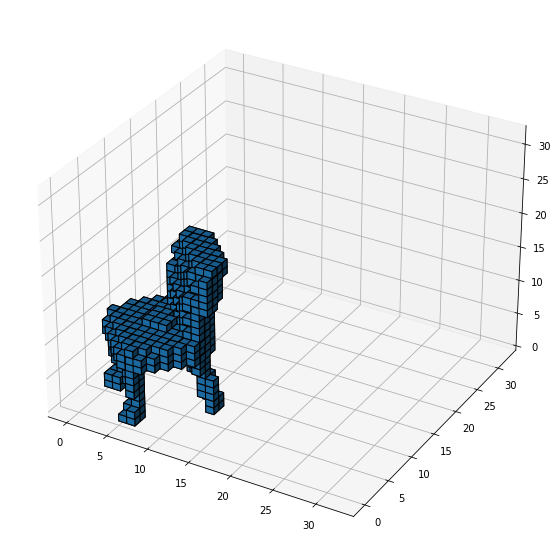

In [5]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/chair/train/chair_0003.off')
mesh.rotate(r315)
              
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# Dataset setup and Trainer

In [6]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [7]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=10)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=8)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=8)
    

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = 0.5*self.loss_fn(pred1, labels1) + 0.5*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = 0.5*self.loss_fn(pred_test1, labels_test1) + 0.5*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [8]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x
        return self.logsoftmax(x1), self.logsoftmax(x2)

**VoxNet** training

In [9]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 8,
    "lr_scheduler_gamma": 0.3,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
124.71875


Train loss: 1.425458312034607: : 124it [00:18,  6.70it/s]
29it [00:01, 15.45it/s]


epoch:  1 / 50
time: 20.42 seconds
train-loss: 1.58, train-acc-object: 46.09%, train-acc-pose: 36.44%
valid-loss: 1.23, valid-acc-object: 57.05%, train-acc-pose: 51.43%



Train loss: 0.8147928714752197: : 124it [00:11, 10.89it/s]
29it [00:01, 15.32it/s]


epoch:  2 / 50
time: 13.30 seconds
train-loss: 1.02, train-acc-object: 65.17%, train-acc-pose: 55.42%
valid-loss: 0.99, valid-acc-object: 67.51%, train-acc-pose: 57.82%



Train loss: 0.9327528476715088: : 124it [00:11, 10.92it/s]
29it [00:01, 15.45it/s]


epoch:  3 / 50
time: 13.25 seconds
train-loss: 0.83, train-acc-object: 72.35%, train-acc-pose: 63.10%
valid-loss: 0.84, valid-acc-object: 71.26%, train-acc-pose: 64.10%



Train loss: 0.5406292080879211: : 124it [00:11, 10.94it/s]
29it [00:01, 15.42it/s]


epoch:  4 / 50
time: 13.24 seconds
train-loss: 0.70, train-acc-object: 76.76%, train-acc-pose: 68.80%
valid-loss: 0.79, valid-acc-object: 73.68%, train-acc-pose: 67.73%



Train loss: 0.5259391069412231: : 124it [00:12,  9.89it/s]
29it [00:01, 15.15it/s]


epoch:  5 / 50
time: 14.46 seconds
train-loss: 0.63, train-acc-object: 80.57%, train-acc-pose: 71.35%
valid-loss: 0.70, valid-acc-object: 75.77%, train-acc-pose: 69.16%



Train loss: 0.4102342128753662: : 124it [00:11, 10.76it/s]
29it [00:01, 15.07it/s]


epoch:  6 / 50
time: 13.47 seconds
train-loss: 0.54, train-acc-object: 83.09%, train-acc-pose: 74.62%
valid-loss: 0.65, valid-acc-object: 78.19%, train-acc-pose: 70.48%



Train loss: 0.613671064376831: : 124it [00:11, 10.38it/s]
29it [00:01, 15.35it/s]


epoch:  7 / 50
time: 13.85 seconds
train-loss: 0.49, train-acc-object: 84.53%, train-acc-pose: 78.33%
valid-loss: 0.62, valid-acc-object: 80.95%, train-acc-pose: 71.26%



Train loss: 0.3213074803352356: : 124it [00:11, 10.89it/s]
29it [00:01, 15.28it/s]


epoch:  8 / 50
time: 13.30 seconds
train-loss: 0.44, train-acc-object: 87.70%, train-acc-pose: 78.25%
valid-loss: 0.61, valid-acc-object: 80.95%, train-acc-pose: 70.81%



Train loss: 0.22052517533302307: : 124it [00:11, 10.76it/s]
29it [00:01, 15.05it/s]


epoch:  9 / 50
time: 13.47 seconds
train-loss: 0.34, train-acc-object: 90.62%, train-acc-pose: 83.90%
valid-loss: 0.58, valid-acc-object: 81.39%, train-acc-pose: 70.48%



Train loss: 0.19429868459701538: : 124it [00:11, 10.78it/s]
29it [00:01, 15.05it/s]


epoch: 10 / 50
time: 13.44 seconds
train-loss: 0.30, train-acc-object: 91.48%, train-acc-pose: 85.13%
valid-loss: 0.56, valid-acc-object: 81.39%, train-acc-pose: 72.69%



Train loss: 0.2475624978542328: : 124it [00:11, 10.69it/s]
29it [00:01, 14.85it/s]


epoch: 11 / 50
time: 13.56 seconds
train-loss: 0.28, train-acc-object: 91.73%, train-acc-pose: 85.86%
valid-loss: 0.56, valid-acc-object: 82.93%, train-acc-pose: 71.37%



Train loss: 0.37034785747528076: : 124it [00:11, 10.67it/s]
29it [00:02, 13.53it/s]


epoch: 12 / 50
time: 13.78 seconds
train-loss: 0.27, train-acc-object: 93.12%, train-acc-pose: 86.64%
valid-loss: 0.56, valid-acc-object: 82.93%, train-acc-pose: 72.91%



Train loss: 0.34667861461639404: : 124it [00:11, 10.83it/s]
29it [00:02, 12.41it/s]


epoch: 13 / 50
time: 13.82 seconds
train-loss: 0.25, train-acc-object: 93.20%, train-acc-pose: 87.95%
valid-loss: 0.55, valid-acc-object: 82.16%, train-acc-pose: 72.25%



Train loss: 0.24949872493743896: : 124it [00:11, 11.14it/s]
29it [00:02, 11.00it/s]


epoch: 14 / 50
time: 13.79 seconds
train-loss: 0.24, train-acc-object: 93.78%, train-acc-pose: 87.88%
valid-loss: 0.55, valid-acc-object: 83.15%, train-acc-pose: 72.58%



Train loss: 0.24020931124687195: : 124it [00:11, 10.77it/s]
29it [00:03,  9.07it/s]


epoch: 15 / 50
time: 14.72 seconds
train-loss: 0.23, train-acc-object: 93.47%, train-acc-pose: 88.56%
valid-loss: 0.56, valid-acc-object: 83.15%, train-acc-pose: 73.13%



Train loss: 0.14714014530181885: : 124it [00:10, 11.46it/s]
29it [00:02, 10.09it/s]


epoch: 16 / 50
time: 13.72 seconds
train-loss: 0.22, train-acc-object: 94.23%, train-acc-pose: 88.96%
valid-loss: 0.55, valid-acc-object: 83.04%, train-acc-pose: 72.69%



Train loss: 0.2272990643978119: : 124it [00:11, 11.21it/s]
29it [00:02, 10.88it/s]


epoch: 17 / 50
time: 13.74 seconds
train-loss: 0.19, train-acc-object: 95.49%, train-acc-pose: 90.27%
valid-loss: 0.55, valid-acc-object: 83.92%, train-acc-pose: 73.57%



Train loss: 0.17274169623851776: : 124it [00:11, 10.84it/s]
29it [00:02, 12.98it/s]


epoch: 18 / 50
time: 13.69 seconds
train-loss: 0.19, train-acc-object: 95.39%, train-acc-pose: 90.35%
valid-loss: 0.55, valid-acc-object: 83.37%, train-acc-pose: 73.46%



Train loss: 0.194733664393425: : 124it [00:11, 10.72it/s]
29it [00:01, 15.06it/s]


epoch: 19 / 50
time: 13.51 seconds
train-loss: 0.17, train-acc-object: 95.69%, train-acc-pose: 91.48%
valid-loss: 0.56, valid-acc-object: 83.59%, train-acc-pose: 72.80%



Train loss: 0.159109428524971: : 124it [00:11, 10.60it/s]
29it [00:01, 15.16it/s]


epoch: 20 / 50
time: 13.62 seconds
train-loss: 0.17, train-acc-object: 95.67%, train-acc-pose: 91.63%
valid-loss: 0.55, valid-acc-object: 83.37%, train-acc-pose: 73.79%



Train loss: 0.18849609792232513: : 124it [00:11, 10.72it/s]
29it [00:01, 14.63it/s]


epoch: 21 / 50
time: 13.57 seconds
train-loss: 0.16, train-acc-object: 96.57%, train-acc-pose: 91.43%
valid-loss: 0.56, valid-acc-object: 83.92%, train-acc-pose: 72.80%



Train loss: 0.2603920102119446: : 124it [00:12, 10.27it/s]
29it [00:01, 15.12it/s]


epoch: 22 / 50
time: 14.01 seconds
train-loss: 0.16, train-acc-object: 96.07%, train-acc-pose: 91.61%
valid-loss: 0.56, valid-acc-object: 83.04%, train-acc-pose: 73.79%



Train loss: 0.15672357380390167: : 124it [00:11, 10.69it/s]
29it [00:01, 14.79it/s]


epoch: 23 / 50
time: 13.58 seconds
train-loss: 0.15, train-acc-object: 96.30%, train-acc-pose: 92.19%
valid-loss: 0.57, valid-acc-object: 83.26%, train-acc-pose: 72.91%



Train loss: 0.14775756001472473: : 124it [00:11, 10.64it/s]
29it [00:01, 14.86it/s]


epoch: 24 / 50
time: 13.63 seconds
train-loss: 0.16, train-acc-object: 95.92%, train-acc-pose: 91.89%
valid-loss: 0.57, valid-acc-object: 83.26%, train-acc-pose: 73.68%



Train loss: 0.11345765739679337: : 124it [00:11, 10.75it/s]
29it [00:01, 14.99it/s]


epoch: 25 / 50
time: 13.49 seconds
train-loss: 0.15, train-acc-object: 96.62%, train-acc-pose: 92.82%
valid-loss: 0.57, valid-acc-object: 84.03%, train-acc-pose: 73.68%



Train loss: 0.16332770884037018: : 124it [00:11, 10.81it/s]
29it [00:01, 14.64it/s]


epoch: 26 / 50
time: 13.47 seconds
train-loss: 0.15, train-acc-object: 96.98%, train-acc-pose: 92.62%
valid-loss: 0.57, valid-acc-object: 84.14%, train-acc-pose: 73.90%



Train loss: 0.07298097014427185: : 124it [00:11, 10.65it/s]
29it [00:01, 14.83it/s]


epoch: 27 / 50
time: 13.62 seconds
train-loss: 0.14, train-acc-object: 97.10%, train-acc-pose: 92.72%
valid-loss: 0.57, valid-acc-object: 84.14%, train-acc-pose: 73.02%



Train loss: 0.08519771695137024: : 124it [00:11, 10.60it/s]
29it [00:01, 14.62it/s]


epoch: 28 / 50
time: 13.70 seconds
train-loss: 0.15, train-acc-object: 96.60%, train-acc-pose: 92.34%
valid-loss: 0.57, valid-acc-object: 83.92%, train-acc-pose: 74.12%



Train loss: 0.19977542757987976: : 124it [00:11, 10.64it/s]
29it [00:01, 14.63it/s]


epoch: 29 / 50
time: 13.66 seconds
train-loss: 0.14, train-acc-object: 96.80%, train-acc-pose: 92.99%
valid-loss: 0.57, valid-acc-object: 83.92%, train-acc-pose: 73.90%



Train loss: 0.13261868059635162: : 124it [00:11, 10.62it/s]
29it [00:01, 14.87it/s]


epoch: 30 / 50
time: 13.64 seconds
train-loss: 0.14, train-acc-object: 96.57%, train-acc-pose: 92.92%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 74.45%



Train loss: 0.20242205262184143: : 124it [00:11, 10.63it/s]
29it [00:01, 14.74it/s]


epoch: 31 / 50
time: 13.66 seconds
train-loss: 0.14, train-acc-object: 96.67%, train-acc-pose: 93.15%
valid-loss: 0.58, valid-acc-object: 84.14%, train-acc-pose: 74.12%



Train loss: 0.1616547852754593: : 124it [00:11, 10.63it/s]
29it [00:01, 14.85it/s]


epoch: 32 / 50
time: 13.64 seconds
train-loss: 0.14, train-acc-object: 96.77%, train-acc-pose: 92.99%
valid-loss: 0.58, valid-acc-object: 84.14%, train-acc-pose: 73.68%



Train loss: 0.13044798374176025: : 124it [00:11, 10.70it/s]
29it [00:01, 14.67it/s]


epoch: 33 / 50
time: 13.58 seconds
train-loss: 0.14, train-acc-object: 96.90%, train-acc-pose: 92.92%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 73.68%



Train loss: 0.0684661790728569: : 124it [00:11, 10.75it/s]
29it [00:01, 14.75it/s]


epoch: 34 / 50
time: 13.51 seconds
train-loss: 0.13, train-acc-object: 97.20%, train-acc-pose: 93.72%
valid-loss: 0.58, valid-acc-object: 84.14%, train-acc-pose: 73.90%



Train loss: 0.1268407255411148: : 124it [00:11, 10.64it/s]
29it [00:01, 14.65it/s]


epoch: 35 / 50
time: 13.65 seconds
train-loss: 0.14, train-acc-object: 96.50%, train-acc-pose: 93.57%
valid-loss: 0.58, valid-acc-object: 84.03%, train-acc-pose: 73.79%



Train loss: 0.13901519775390625: : 124it [00:11, 10.60it/s]
29it [00:01, 14.86it/s]


epoch: 36 / 50
time: 13.67 seconds
train-loss: 0.13, train-acc-object: 96.88%, train-acc-pose: 94.13%
valid-loss: 0.58, valid-acc-object: 84.14%, train-acc-pose: 74.12%



Train loss: 0.15053902566432953: : 124it [00:11, 10.61it/s]
29it [00:02, 12.86it/s]


epoch: 37 / 50
time: 13.96 seconds
train-loss: 0.13, train-acc-object: 97.05%, train-acc-pose: 93.40%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 74.23%



Train loss: 0.10898762941360474: : 124it [00:11, 10.96it/s]
29it [00:02, 11.04it/s]


epoch: 38 / 50
time: 13.96 seconds
train-loss: 0.13, train-acc-object: 96.95%, train-acc-pose: 93.30%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.79%



Train loss: 0.2372903823852539: : 124it [00:11, 11.26it/s]
29it [00:02,  9.86it/s]


epoch: 39 / 50
time: 13.97 seconds
train-loss: 0.13, train-acc-object: 97.18%, train-acc-pose: 93.37%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.46%



Train loss: 0.059887126088142395: : 124it [00:10, 11.34it/s]
29it [00:03,  9.42it/s]


epoch: 40 / 50
time: 14.03 seconds
train-loss: 0.13, train-acc-object: 97.40%, train-acc-pose: 93.30%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.57%



Train loss: 0.11910093575716019: : 124it [00:11, 11.21it/s]
29it [00:02, 10.86it/s]


epoch: 41 / 50
time: 13.74 seconds
train-loss: 0.13, train-acc-object: 96.72%, train-acc-pose: 93.07%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.57%



Train loss: 0.08275540173053741: : 124it [00:11, 10.95it/s]
29it [00:02, 12.69it/s]


epoch: 42 / 50
time: 13.63 seconds
train-loss: 0.13, train-acc-object: 97.25%, train-acc-pose: 93.40%
valid-loss: 0.58, valid-acc-object: 84.36%, train-acc-pose: 73.46%



Train loss: 0.14876580238342285: : 124it [00:11, 10.61it/s]
29it [00:01, 14.58it/s]


epoch: 43 / 50
time: 13.69 seconds
train-loss: 0.13, train-acc-object: 97.48%, train-acc-pose: 94.08%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.24%



Train loss: 0.07249540835618973: : 124it [00:11, 10.62it/s]
29it [00:01, 14.65it/s]


epoch: 44 / 50
time: 13.68 seconds
train-loss: 0.13, train-acc-object: 96.67%, train-acc-pose: 93.45%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.46%



Train loss: 0.10780216008424759: : 124it [00:11, 10.65it/s]
29it [00:01, 14.78it/s]


epoch: 45 / 50
time: 13.62 seconds
train-loss: 0.13, train-acc-object: 96.85%, train-acc-pose: 93.72%
valid-loss: 0.58, valid-acc-object: 84.36%, train-acc-pose: 73.68%



Train loss: 0.12856830656528473: : 124it [00:11, 10.60it/s]
29it [00:02, 14.33it/s]


epoch: 46 / 50
time: 13.74 seconds
train-loss: 0.13, train-acc-object: 97.23%, train-acc-pose: 93.27%
valid-loss: 0.58, valid-acc-object: 84.36%, train-acc-pose: 73.68%



Train loss: 0.20651614665985107: : 124it [00:11, 10.61it/s]
29it [00:01, 14.54it/s]


epoch: 47 / 50
time: 13.70 seconds
train-loss: 0.13, train-acc-object: 96.88%, train-acc-pose: 93.75%
valid-loss: 0.58, valid-acc-object: 84.36%, train-acc-pose: 73.79%



Train loss: 0.08335132896900177: : 124it [00:11, 10.68it/s]
29it [00:01, 14.60it/s]


epoch: 48 / 50
time: 13.61 seconds
train-loss: 0.13, train-acc-object: 97.25%, train-acc-pose: 93.50%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.79%



Train loss: 0.14553920924663544: : 124it [00:11, 10.53it/s]
29it [00:01, 14.77it/s]


epoch: 49 / 50
time: 13.76 seconds
train-loss: 0.13, train-acc-object: 97.30%, train-acc-pose: 93.75%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.79%



Train loss: 0.1587783694267273: : 124it [00:11, 10.62it/s]
29it [00:01, 14.72it/s]

epoch: 50 / 50
time: 13.66 seconds
train-loss: 0.13, train-acc-object: 97.45%, train-acc-pose: 93.04%
valid-loss: 0.58, valid-acc-object: 84.25%, train-acc-pose: 73.68%



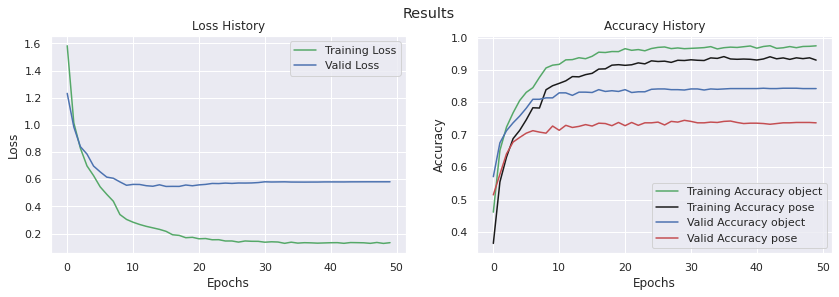

In [10]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

best model was trained at epoch: 42
with a validation loss of: 0.58064353 and a validation accuracy of: 84.36123132705688


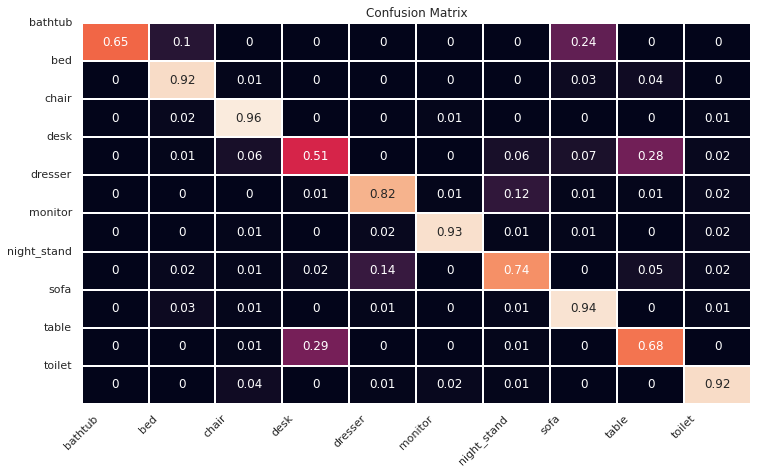

In [11]:
trainer1.generateConfusionMatrix()

best model was trained at epoch: 42
with a validation loss of: 0.58064353 and a validation accuracy of: 84.36123132705688


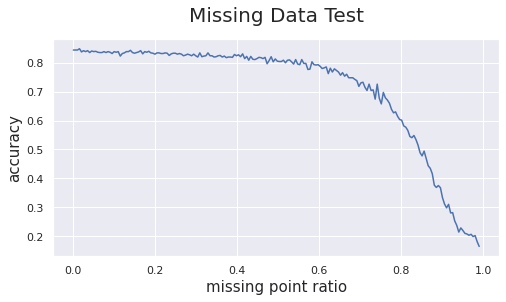

In [22]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [13]:
from collections import OrderedDict
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return x1, x2
        #return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training 

In [14]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.3,
    "train_batch_size": 64,
    "valid_batch_size": 64,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
62.359375


Train loss: 1.138354778289795: : 62it [00:16,  3.65it/s]
15it [00:02,  6.85it/s]


epoch:  1 / 50
time: 19.17 seconds
train-loss: 1.52, train-acc-object: 46.30%, train-acc-pose: 39.67%
valid-loss: 1.40, valid-acc-object: 52.31%, train-acc-pose: 54.52%



Train loss: 0.7934739589691162: : 62it [00:17,  3.58it/s]
15it [00:02,  6.08it/s]


epoch:  2 / 50
time: 19.79 seconds
train-loss: 0.93, train-acc-object: 69.71%, train-acc-pose: 59.45%
valid-loss: 0.88, valid-acc-object: 69.49%, train-acc-pose: 60.79%



Train loss: 0.6190327405929565: : 62it [00:16,  3.66it/s]
15it [00:02,  6.78it/s]


epoch:  3 / 50
time: 19.16 seconds
train-loss: 0.70, train-acc-object: 77.34%, train-acc-pose: 69.35%
valid-loss: 0.75, valid-acc-object: 74.34%, train-acc-pose: 68.17%



Train loss: 0.5813194513320923: : 62it [00:17,  3.52it/s]
15it [00:02,  6.59it/s]


epoch:  4 / 50
time: 19.93 seconds
train-loss: 0.59, train-acc-object: 81.20%, train-acc-pose: 72.45%
valid-loss: 0.68, valid-acc-object: 74.23%, train-acc-pose: 68.39%



Train loss: 0.5643555521965027: : 62it [00:17,  3.65it/s]
15it [00:02,  6.73it/s]


epoch:  5 / 50
time: 19.24 seconds
train-loss: 0.51, train-acc-object: 83.95%, train-acc-pose: 75.98%
valid-loss: 0.64, valid-acc-object: 78.19%, train-acc-pose: 71.15%



Train loss: 0.35454800724983215: : 62it [00:17,  3.49it/s]
15it [00:02,  6.86it/s]


epoch:  6 / 50
time: 19.97 seconds
train-loss: 0.47, train-acc-object: 85.89%, train-acc-pose: 77.42%
valid-loss: 0.58, valid-acc-object: 79.63%, train-acc-pose: 71.59%



Train loss: 0.41103988885879517: : 62it [00:17,  3.61it/s]
15it [00:02,  6.78it/s]


epoch:  7 / 50
time: 19.38 seconds
train-loss: 0.42, train-acc-object: 86.57%, train-acc-pose: 79.36%
valid-loss: 0.55, valid-acc-object: 82.60%, train-acc-pose: 72.69%



Train loss: 0.47973117232322693: : 62it [00:17,  3.48it/s]
15it [00:02,  6.90it/s]


epoch:  8 / 50
time: 19.99 seconds
train-loss: 0.38, train-acc-object: 89.14%, train-acc-pose: 80.65%
valid-loss: 0.53, valid-acc-object: 84.03%, train-acc-pose: 72.69%



Train loss: 0.2072095423936844: : 62it [00:17,  3.63it/s]
15it [00:02,  6.77it/s]


epoch:  9 / 50
time: 19.31 seconds
train-loss: 0.34, train-acc-object: 90.93%, train-acc-pose: 81.68%
valid-loss: 0.50, valid-acc-object: 85.57%, train-acc-pose: 73.24%



Train loss: 0.28178757429122925: : 62it [00:17,  3.49it/s]
15it [00:02,  6.77it/s]


epoch: 10 / 50
time: 19.98 seconds
train-loss: 0.32, train-acc-object: 91.46%, train-acc-pose: 82.76%
valid-loss: 0.52, valid-acc-object: 82.82%, train-acc-pose: 72.47%



Train loss: 0.2133176326751709: : 62it [00:17,  3.62it/s]
15it [00:02,  6.70it/s]


epoch: 11 / 50
time: 19.37 seconds
train-loss: 0.26, train-acc-object: 93.09%, train-acc-pose: 85.64%
valid-loss: 0.49, valid-acc-object: 85.46%, train-acc-pose: 72.14%



Train loss: 0.22629523277282715: : 62it [00:17,  3.49it/s]
15it [00:02,  6.76it/s]


epoch: 12 / 50
time: 20.01 seconds
train-loss: 0.22, train-acc-object: 94.81%, train-acc-pose: 87.17%
valid-loss: 0.49, valid-acc-object: 85.35%, train-acc-pose: 73.46%



Train loss: 0.38236767053604126: : 62it [00:17,  3.64it/s]
15it [00:02,  6.25it/s]


epoch: 13 / 50
time: 19.46 seconds
train-loss: 0.21, train-acc-object: 94.63%, train-acc-pose: 87.65%
valid-loss: 0.49, valid-acc-object: 85.90%, train-acc-pose: 73.24%



Train loss: 0.21514058113098145: : 62it [00:17,  3.53it/s]
15it [00:02,  6.92it/s]


epoch: 14 / 50
time: 19.75 seconds
train-loss: 0.20, train-acc-object: 95.49%, train-acc-pose: 88.68%
valid-loss: 0.49, valid-acc-object: 84.47%, train-acc-pose: 73.90%



Train loss: 0.19232308864593506: : 62it [00:17,  3.63it/s]
15it [00:02,  5.60it/s]


epoch: 15 / 50
time: 19.78 seconds
train-loss: 0.19, train-acc-object: 95.74%, train-acc-pose: 88.89%
valid-loss: 0.48, valid-acc-object: 85.68%, train-acc-pose: 75.33%



Train loss: 0.12015329301357269: : 62it [00:17,  3.55it/s]
15it [00:02,  6.86it/s]


epoch: 16 / 50
time: 19.69 seconds
train-loss: 0.19, train-acc-object: 95.41%, train-acc-pose: 89.04%
valid-loss: 0.48, valid-acc-object: 85.68%, train-acc-pose: 75.22%



Train loss: 0.19874030351638794: : 62it [00:17,  3.64it/s]
15it [00:02,  5.01it/s]


epoch: 17 / 50
time: 20.02 seconds
train-loss: 0.18, train-acc-object: 95.69%, train-acc-pose: 89.77%
valid-loss: 0.49, valid-acc-object: 85.46%, train-acc-pose: 73.90%



Train loss: 0.08311029523611069: : 62it [00:17,  3.58it/s]
15it [00:02,  6.78it/s]


epoch: 18 / 50
time: 19.55 seconds
train-loss: 0.17, train-acc-object: 96.09%, train-acc-pose: 89.52%
valid-loss: 0.49, valid-acc-object: 85.79%, train-acc-pose: 73.68%



Train loss: 0.26238980889320374: : 62it [00:17,  3.62it/s]
15it [00:03,  4.43it/s]


epoch: 19 / 50
time: 20.54 seconds
train-loss: 0.17, train-acc-object: 96.50%, train-acc-pose: 89.94%
valid-loss: 0.50, valid-acc-object: 84.80%, train-acc-pose: 76.32%



Train loss: 0.16233010590076447: : 62it [00:17,  3.63it/s]
15it [00:02,  6.97it/s]


epoch: 20 / 50
time: 19.23 seconds
train-loss: 0.17, train-acc-object: 96.04%, train-acc-pose: 90.05%
valid-loss: 0.48, valid-acc-object: 85.79%, train-acc-pose: 75.00%



Train loss: 0.1433233767747879: : 62it [00:17,  3.59it/s]
15it [00:03,  4.80it/s]


epoch: 21 / 50
time: 20.40 seconds
train-loss: 0.15, train-acc-object: 96.98%, train-acc-pose: 91.68%
valid-loss: 0.48, valid-acc-object: 85.79%, train-acc-pose: 75.33%



Train loss: 0.17803041636943817: : 62it [00:17,  3.65it/s]
15it [00:02,  6.88it/s]


epoch: 22 / 50
time: 19.20 seconds
train-loss: 0.14, train-acc-object: 96.90%, train-acc-pose: 92.01%
valid-loss: 0.48, valid-acc-object: 86.23%, train-acc-pose: 75.33%



Train loss: 0.19384165108203888: : 62it [00:17,  3.55it/s]
15it [00:02,  5.76it/s]


epoch: 23 / 50
time: 20.09 seconds
train-loss: 0.13, train-acc-object: 97.56%, train-acc-pose: 91.91%
valid-loss: 0.49, valid-acc-object: 85.90%, train-acc-pose: 75.55%



Train loss: 0.13280946016311646: : 62it [00:17,  3.60it/s]
15it [00:02,  6.79it/s]


epoch: 24 / 50
time: 19.46 seconds
train-loss: 0.13, train-acc-object: 97.68%, train-acc-pose: 92.44%
valid-loss: 0.49, valid-acc-object: 85.90%, train-acc-pose: 76.32%



Train loss: 0.11646707355976105: : 62it [00:17,  3.53it/s]
15it [00:02,  6.46it/s]


epoch: 25 / 50
time: 19.92 seconds
train-loss: 0.13, train-acc-object: 97.63%, train-acc-pose: 92.97%
valid-loss: 0.50, valid-acc-object: 85.68%, train-acc-pose: 75.44%



Train loss: 0.11222009360790253: : 62it [00:17,  3.64it/s]
15it [00:02,  6.87it/s]


epoch: 26 / 50
time: 19.22 seconds
train-loss: 0.13, train-acc-object: 97.68%, train-acc-pose: 92.72%
valid-loss: 0.49, valid-acc-object: 85.79%, train-acc-pose: 75.22%



Train loss: 0.11082930862903595: : 62it [00:17,  3.49it/s]
15it [00:02,  6.71it/s]


epoch: 27 / 50
time: 20.02 seconds
train-loss: 0.12, train-acc-object: 97.56%, train-acc-pose: 92.74%
valid-loss: 0.50, valid-acc-object: 85.90%, train-acc-pose: 75.88%



Train loss: 0.12901252508163452: : 62it [00:17,  3.65it/s]
15it [00:02,  6.76it/s]


epoch: 28 / 50
time: 19.24 seconds
train-loss: 0.13, train-acc-object: 97.23%, train-acc-pose: 92.99%
valid-loss: 0.49, valid-acc-object: 86.34%, train-acc-pose: 75.33%



Train loss: 0.1165170893073082: : 62it [00:17,  3.49it/s]
15it [00:02,  6.84it/s]


epoch: 29 / 50
time: 19.96 seconds
train-loss: 0.12, train-acc-object: 97.73%, train-acc-pose: 92.39%
valid-loss: 0.50, valid-acc-object: 86.12%, train-acc-pose: 74.67%



Train loss: 0.08214307576417923: : 62it [00:17,  3.63it/s]
15it [00:02,  6.87it/s]


epoch: 30 / 50
time: 19.26 seconds
train-loss: 0.12, train-acc-object: 97.28%, train-acc-pose: 92.89%
valid-loss: 0.50, valid-acc-object: 86.01%, train-acc-pose: 74.67%



Train loss: 0.08652319014072418: : 62it [00:17,  3.48it/s]
15it [00:02,  6.63it/s]


epoch: 31 / 50
time: 20.08 seconds
train-loss: 0.11, train-acc-object: 97.78%, train-acc-pose: 93.37%
valid-loss: 0.49, valid-acc-object: 85.90%, train-acc-pose: 75.33%



Train loss: 0.1623106151819229: : 62it [00:17,  3.62it/s]
15it [00:02,  6.75it/s]


epoch: 32 / 50
time: 19.36 seconds
train-loss: 0.12, train-acc-object: 98.14%, train-acc-pose: 92.97%
valid-loss: 0.50, valid-acc-object: 85.35%, train-acc-pose: 75.33%



Train loss: 0.12094437330961227: : 62it [00:17,  3.49it/s]
15it [00:02,  6.75it/s]


epoch: 33 / 50
time: 20.01 seconds
train-loss: 0.12, train-acc-object: 97.63%, train-acc-pose: 92.79%
valid-loss: 0.50, valid-acc-object: 85.90%, train-acc-pose: 75.88%



Train loss: 0.111642986536026: : 62it [00:17,  3.61it/s]
15it [00:02,  6.72it/s]


epoch: 34 / 50
time: 19.43 seconds
train-loss: 0.11, train-acc-object: 97.48%, train-acc-pose: 93.65%
valid-loss: 0.50, valid-acc-object: 86.12%, train-acc-pose: 75.44%



Train loss: 0.12427888065576553: : 62it [00:17,  3.50it/s]
15it [00:02,  6.85it/s]


epoch: 35 / 50
time: 19.93 seconds
train-loss: 0.11, train-acc-object: 98.14%, train-acc-pose: 93.45%
valid-loss: 0.50, valid-acc-object: 85.90%, train-acc-pose: 75.33%



Train loss: 0.14317603409290314: : 62it [00:17,  3.62it/s]
15it [00:02,  6.38it/s]


epoch: 36 / 50
time: 19.48 seconds
train-loss: 0.11, train-acc-object: 97.91%, train-acc-pose: 93.72%
valid-loss: 0.50, valid-acc-object: 85.90%, train-acc-pose: 75.55%



Train loss: 0.1569945216178894: : 62it [00:17,  3.51it/s]
15it [00:02,  6.84it/s]


epoch: 37 / 50
time: 19.89 seconds
train-loss: 0.11, train-acc-object: 98.06%, train-acc-pose: 93.30%
valid-loss: 0.50, valid-acc-object: 86.01%, train-acc-pose: 75.99%



Train loss: 0.10704216361045837: : 62it [00:17,  3.62it/s]
15it [00:02,  5.65it/s]


epoch: 38 / 50
time: 19.80 seconds
train-loss: 0.11, train-acc-object: 98.39%, train-acc-pose: 93.57%
valid-loss: 0.50, valid-acc-object: 86.01%, train-acc-pose: 75.44%



Train loss: 0.09486907720565796: : 62it [00:17,  3.52it/s]
15it [00:02,  6.69it/s]


epoch: 39 / 50
time: 19.85 seconds
train-loss: 0.11, train-acc-object: 97.61%, train-acc-pose: 93.42%
valid-loss: 0.50, valid-acc-object: 86.01%, train-acc-pose: 75.55%



Train loss: 0.07431021332740784: : 62it [00:17,  3.60it/s]
15it [00:03,  4.78it/s]


epoch: 40 / 50
time: 20.39 seconds
train-loss: 0.11, train-acc-object: 97.86%, train-acc-pose: 93.50%
valid-loss: 0.50, valid-acc-object: 86.01%, train-acc-pose: 75.77%



Train loss: 0.13642901182174683: : 62it [00:17,  3.55it/s]
15it [00:02,  6.77it/s]


epoch: 41 / 50
time: 19.69 seconds
train-loss: 0.11, train-acc-object: 97.81%, train-acc-pose: 93.55%
valid-loss: 0.50, valid-acc-object: 86.23%, train-acc-pose: 75.55%



Train loss: 0.09944070130586624: : 62it [00:17,  3.59it/s]
15it [00:03,  4.61it/s]


epoch: 42 / 50
time: 20.52 seconds
train-loss: 0.11, train-acc-object: 98.41%, train-acc-pose: 94.10%
valid-loss: 0.50, valid-acc-object: 86.34%, train-acc-pose: 75.44%



Train loss: 0.11701485514640808: : 62it [00:17,  3.61it/s]
15it [00:02,  6.78it/s]


epoch: 43 / 50
time: 19.41 seconds
train-loss: 0.11, train-acc-object: 98.03%, train-acc-pose: 93.93%
valid-loss: 0.50, valid-acc-object: 86.12%, train-acc-pose: 75.00%



Train loss: 0.10663293302059174: : 62it [00:17,  3.53it/s]
15it [00:02,  5.34it/s]


epoch: 44 / 50
time: 20.37 seconds
train-loss: 0.11, train-acc-object: 97.93%, train-acc-pose: 93.32%
valid-loss: 0.50, valid-acc-object: 86.12%, train-acc-pose: 75.11%



Train loss: 0.11459323763847351: : 62it [00:17,  3.59it/s]
15it [00:02,  6.77it/s]


epoch: 45 / 50
time: 19.50 seconds
train-loss: 0.11, train-acc-object: 98.19%, train-acc-pose: 93.50%
valid-loss: 0.50, valid-acc-object: 86.34%, train-acc-pose: 75.22%



Train loss: 0.10386385768651962: : 62it [00:17,  3.48it/s]
15it [00:02,  6.57it/s]


epoch: 46 / 50
time: 20.13 seconds
train-loss: 0.11, train-acc-object: 97.98%, train-acc-pose: 93.90%
valid-loss: 0.50, valid-acc-object: 86.34%, train-acc-pose: 75.55%



Train loss: 0.1008167490363121: : 62it [00:17,  3.60it/s]
15it [00:02,  6.57it/s]


epoch: 47 / 50
time: 19.54 seconds
train-loss: 0.10, train-acc-object: 98.21%, train-acc-pose: 93.55%
valid-loss: 0.50, valid-acc-object: 86.23%, train-acc-pose: 75.44%



Train loss: 0.09855616092681885: : 62it [00:17,  3.46it/s]
15it [00:02,  6.51it/s]


epoch: 48 / 50
time: 20.22 seconds
train-loss: 0.11, train-acc-object: 98.03%, train-acc-pose: 93.47%
valid-loss: 0.50, valid-acc-object: 86.23%, train-acc-pose: 75.55%



Train loss: 0.16739323735237122: : 62it [00:17,  3.60it/s]
15it [00:02,  6.60it/s]


epoch: 49 / 50
time: 19.52 seconds
train-loss: 0.11, train-acc-object: 97.98%, train-acc-pose: 93.83%
valid-loss: 0.50, valid-acc-object: 86.34%, train-acc-pose: 75.55%



Train loss: 0.10923036932945251: : 62it [00:17,  3.47it/s]
15it [00:02,  6.71it/s]

epoch: 50 / 50
time: 20.13 seconds
train-loss: 0.10, train-acc-object: 98.34%, train-acc-pose: 94.05%
valid-loss: 0.50, valid-acc-object: 86.34%, train-acc-pose: 75.77%



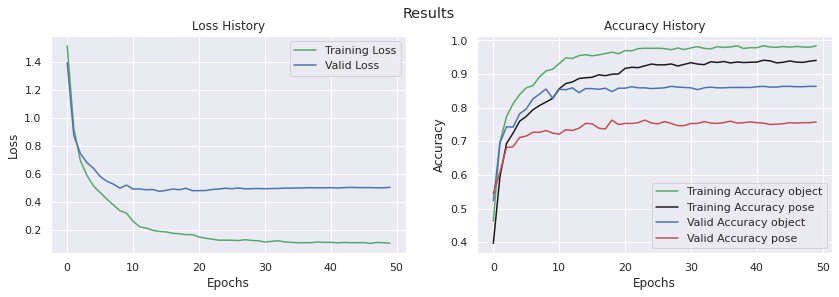

In [15]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 28
with a validation loss of: 0.49360126 and a validation accuracy of: 86.34361028671265


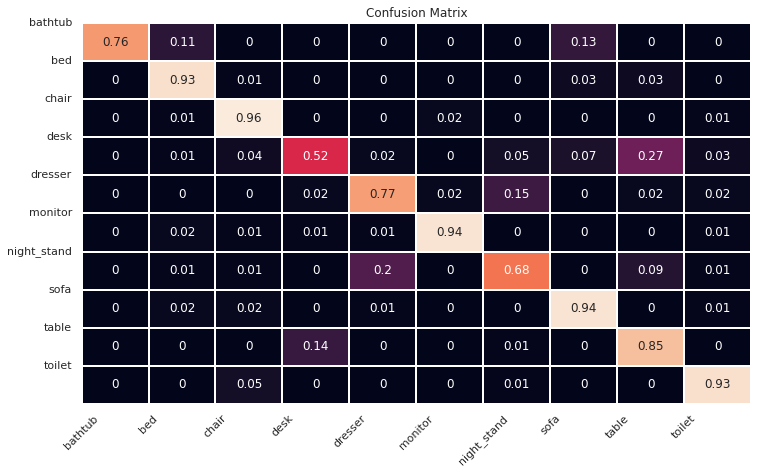

In [16]:
trainer2.generateConfusionMatrix()

best model was trained at epoch: 28
with a validation loss of: 0.49360126 and a validation accuracy of: 86.34361028671265


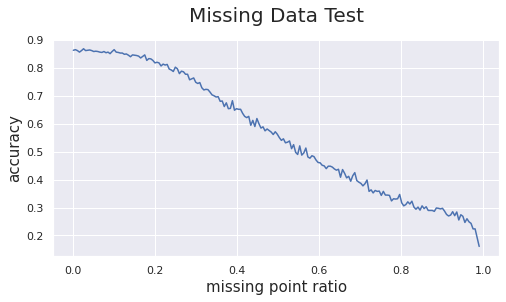

In [23]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [17]:
from collections import OrderedDict
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('relu1', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(2)),
            ('drop1', torch.nn.Dropout(p=0.5)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.5))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return x1, x2
        #return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [18]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
124.71875


Train loss: 1.1632299423217773: : 124it [00:14,  8.32it/s]
29it [00:02, 13.79it/s]


epoch:  1 / 50
time: 17.02 seconds
train-loss: 1.53, train-acc-object: 46.14%, train-acc-pose: 38.36%
valid-loss: 1.19, valid-acc-object: 57.82%, train-acc-pose: 53.41%



Train loss: 0.8625174760818481: : 124it [00:13,  9.35it/s]
29it [00:02,  9.87it/s]


epoch:  2 / 50
time: 16.21 seconds
train-loss: 1.02, train-acc-object: 61.52%, train-acc-pose: 58.92%
valid-loss: 1.02, valid-acc-object: 62.00%, train-acc-pose: 59.03%



Train loss: 0.7679438591003418: : 124it [00:13,  9.21it/s]
29it [00:02, 13.49it/s]


epoch:  3 / 50
time: 15.64 seconds
train-loss: 0.85, train-acc-object: 69.30%, train-acc-pose: 65.68%
valid-loss: 0.87, valid-acc-object: 65.97%, train-acc-pose: 64.76%



Train loss: 0.8214214444160461: : 124it [00:13,  9.05it/s]
29it [00:02, 13.21it/s]


epoch:  4 / 50
time: 15.91 seconds
train-loss: 0.74, train-acc-object: 75.05%, train-acc-pose: 68.72%
valid-loss: 0.78, valid-acc-object: 70.26%, train-acc-pose: 63.88%



Train loss: 0.6018863916397095: : 124it [00:14,  8.76it/s]
29it [00:02,  9.86it/s]


epoch:  5 / 50
time: 17.11 seconds
train-loss: 0.66, train-acc-object: 76.89%, train-acc-pose: 71.04%
valid-loss: 0.66, valid-acc-object: 77.86%, train-acc-pose: 71.59%



Train loss: 0.5034410953521729: : 124it [00:14,  8.61it/s]
29it [00:02, 12.51it/s]


epoch:  6 / 50
time: 16.74 seconds
train-loss: 0.59, train-acc-object: 80.95%, train-acc-pose: 74.24%
valid-loss: 0.63, valid-acc-object: 79.30%, train-acc-pose: 70.15%



Train loss: 0.390534371137619: : 124it [00:13,  8.93it/s]
29it [00:02, 13.59it/s]


epoch:  7 / 50
time: 16.04 seconds
train-loss: 0.53, train-acc-object: 82.89%, train-acc-pose: 76.08%
valid-loss: 0.60, valid-acc-object: 80.18%, train-acc-pose: 73.13%



Train loss: 0.37204688787460327: : 124it [00:13,  8.86it/s]
29it [00:02,  9.82it/s]


epoch:  8 / 50
time: 16.96 seconds
train-loss: 0.49, train-acc-object: 84.95%, train-acc-pose: 77.29%
valid-loss: 0.57, valid-acc-object: 81.06%, train-acc-pose: 72.80%



Train loss: 0.6411606073379517: : 124it [00:13,  8.93it/s]
29it [00:02, 13.30it/s]


epoch:  9 / 50
time: 16.09 seconds
train-loss: 0.46, train-acc-object: 85.03%, train-acc-pose: 78.70%
valid-loss: 0.55, valid-acc-object: 81.94%, train-acc-pose: 74.56%



Train loss: 0.3039264678955078: : 124it [00:13,  9.10it/s]
29it [00:02, 13.51it/s]


epoch: 10 / 50
time: 15.79 seconds
train-loss: 0.43, train-acc-object: 86.84%, train-acc-pose: 79.33%
valid-loss: 0.54, valid-acc-object: 83.26%, train-acc-pose: 72.80%



Train loss: 0.41997748613357544: : 124it [00:14,  8.85it/s]
29it [00:02, 10.25it/s]


epoch: 11 / 50
time: 16.87 seconds
train-loss: 0.37, train-acc-object: 89.36%, train-acc-pose: 82.06%
valid-loss: 0.53, valid-acc-object: 81.06%, train-acc-pose: 74.01%



Train loss: 0.5009243488311768: : 124it [00:14,  8.68it/s]
29it [00:02, 13.09it/s]


epoch: 12 / 50
time: 16.52 seconds
train-loss: 0.34, train-acc-object: 90.37%, train-acc-pose: 83.37%
valid-loss: 0.51, valid-acc-object: 83.15%, train-acc-pose: 73.13%



Train loss: 0.3494393229484558: : 124it [00:13,  8.89it/s]
29it [00:02, 13.33it/s]


epoch: 13 / 50
time: 16.14 seconds
train-loss: 0.32, train-acc-object: 90.80%, train-acc-pose: 84.17%
valid-loss: 0.54, valid-acc-object: 82.16%, train-acc-pose: 74.12%



Train loss: 0.24530161917209625: : 124it [00:13,  9.19it/s]
29it [00:02, 12.00it/s]


epoch: 14 / 50
time: 15.92 seconds
train-loss: 0.32, train-acc-object: 90.57%, train-acc-pose: 83.54%
valid-loss: 0.52, valid-acc-object: 84.47%, train-acc-pose: 74.01%



Train loss: 0.15707819163799286: : 124it [00:14,  8.80it/s]
29it [00:02, 13.13it/s]


epoch: 15 / 50
time: 16.32 seconds
train-loss: 0.31, train-acc-object: 91.38%, train-acc-pose: 84.68%
valid-loss: 0.53, valid-acc-object: 84.03%, train-acc-pose: 75.11%



Train loss: 0.32648611068725586: : 124it [00:13,  9.11it/s]
29it [00:02, 13.41it/s]


epoch: 16 / 50
time: 15.79 seconds
train-loss: 0.29, train-acc-object: 91.03%, train-acc-pose: 85.61%
valid-loss: 0.52, valid-acc-object: 83.26%, train-acc-pose: 75.00%



Train loss: 0.23742400109767914: : 124it [00:13,  9.02it/s]
29it [00:02, 13.54it/s]


epoch: 17 / 50
time: 15.90 seconds
train-loss: 0.28, train-acc-object: 91.96%, train-acc-pose: 85.91%
valid-loss: 0.53, valid-acc-object: 82.93%, train-acc-pose: 74.12%



Train loss: 0.24997323751449585: : 124it [00:13,  9.06it/s]
29it [00:02, 10.23it/s]


epoch: 18 / 50
time: 16.54 seconds
train-loss: 0.27, train-acc-object: 92.57%, train-acc-pose: 85.86%
valid-loss: 0.52, valid-acc-object: 82.71%, train-acc-pose: 76.10%



Train loss: 0.20206581056118011: : 124it [00:13,  9.15it/s]
29it [00:02, 13.36it/s]


epoch: 19 / 50
time: 15.74 seconds
train-loss: 0.26, train-acc-object: 92.24%, train-acc-pose: 86.39%
valid-loss: 0.51, valid-acc-object: 83.26%, train-acc-pose: 75.66%



Train loss: 0.25942307710647583: : 124it [00:13,  9.09it/s]
29it [00:02, 13.46it/s]


epoch: 20 / 50
time: 15.82 seconds
train-loss: 0.25, train-acc-object: 93.85%, train-acc-pose: 87.83%
valid-loss: 0.51, valid-acc-object: 84.58%, train-acc-pose: 75.99%



Train loss: 0.300218403339386: : 124it [00:13,  9.10it/s]
29it [00:02, 10.17it/s]


epoch: 21 / 50
time: 16.49 seconds
train-loss: 0.24, train-acc-object: 93.25%, train-acc-pose: 88.13%
valid-loss: 0.50, valid-acc-object: 83.81%, train-acc-pose: 75.88%



Train loss: 0.1423478126525879: : 124it [00:13,  9.04it/s]
29it [00:02, 13.39it/s]


epoch: 22 / 50
time: 15.89 seconds
train-loss: 0.22, train-acc-object: 93.98%, train-acc-pose: 89.44%
valid-loss: 0.52, valid-acc-object: 83.70%, train-acc-pose: 77.09%



Train loss: 0.23798242211341858: : 124it [00:13,  9.07it/s]
29it [00:02, 13.33it/s]


epoch: 23 / 50
time: 15.87 seconds
train-loss: 0.21, train-acc-object: 94.18%, train-acc-pose: 89.57%
valid-loss: 0.52, valid-acc-object: 84.80%, train-acc-pose: 75.77%



Train loss: 0.34600430727005005: : 124it [00:13,  9.08it/s]
29it [00:02, 13.42it/s]


epoch: 24 / 50
time: 15.84 seconds
train-loss: 0.22, train-acc-object: 94.23%, train-acc-pose: 89.24%
valid-loss: 0.51, valid-acc-object: 85.24%, train-acc-pose: 76.43%



Train loss: 0.2166353166103363: : 124it [00:14,  8.83it/s]
29it [00:02, 12.30it/s]


epoch: 25 / 50
time: 16.41 seconds
train-loss: 0.21, train-acc-object: 94.46%, train-acc-pose: 89.47%
valid-loss: 0.52, valid-acc-object: 84.47%, train-acc-pose: 75.99%



Train loss: 0.22837680578231812: : 124it [00:13,  9.07it/s]
29it [00:02, 13.22it/s]


epoch: 26 / 50
time: 15.89 seconds
train-loss: 0.20, train-acc-object: 94.98%, train-acc-pose: 89.44%
valid-loss: 0.52, valid-acc-object: 85.02%, train-acc-pose: 75.33%



Train loss: 0.23205438256263733: : 124it [00:13,  9.03it/s]
29it [00:02, 13.39it/s]


epoch: 27 / 50
time: 15.92 seconds
train-loss: 0.19, train-acc-object: 95.01%, train-acc-pose: 89.59%
valid-loss: 0.52, valid-acc-object: 84.36%, train-acc-pose: 75.99%



Train loss: 0.20714613795280457: : 124it [00:13,  9.03it/s]
29it [00:03,  9.62it/s]


epoch: 28 / 50
time: 16.76 seconds
train-loss: 0.20, train-acc-object: 94.41%, train-acc-pose: 89.82%
valid-loss: 0.52, valid-acc-object: 84.14%, train-acc-pose: 76.21%



Train loss: 0.21856436133384705: : 124it [00:13,  9.00it/s]
29it [00:02, 13.42it/s]


epoch: 29 / 50
time: 15.96 seconds
train-loss: 0.20, train-acc-object: 94.96%, train-acc-pose: 89.19%
valid-loss: 0.54, valid-acc-object: 82.71%, train-acc-pose: 75.66%



Train loss: 0.3333593010902405: : 124it [00:13,  9.15it/s]
29it [00:02, 13.14it/s]


epoch: 30 / 50
time: 15.77 seconds
train-loss: 0.19, train-acc-object: 95.34%, train-acc-pose: 90.02%
valid-loss: 0.54, valid-acc-object: 85.02%, train-acc-pose: 75.66%



Train loss: 0.19074293971061707: : 124it [00:13,  8.97it/s]
29it [00:02,  9.74it/s]


epoch: 31 / 50
time: 16.82 seconds
train-loss: 0.18, train-acc-object: 95.41%, train-acc-pose: 90.12%
valid-loss: 0.53, valid-acc-object: 84.36%, train-acc-pose: 76.54%



Train loss: 0.260814368724823: : 124it [00:13,  8.93it/s]
29it [00:02, 13.33it/s]


epoch: 32 / 50
time: 16.07 seconds
train-loss: 0.17, train-acc-object: 95.19%, train-acc-pose: 91.08%
valid-loss: 0.54, valid-acc-object: 84.47%, train-acc-pose: 76.10%



Train loss: 0.22518819570541382: : 124it [00:13,  8.97it/s]
29it [00:02, 13.18it/s]


epoch: 33 / 50
time: 16.05 seconds
train-loss: 0.17, train-acc-object: 95.41%, train-acc-pose: 91.03%
valid-loss: 0.54, valid-acc-object: 84.69%, train-acc-pose: 76.43%



Train loss: 0.1849265992641449: : 124it [00:14,  8.84it/s]
29it [00:02, 11.01it/s]


epoch: 34 / 50
time: 16.67 seconds
train-loss: 0.17, train-acc-object: 95.99%, train-acc-pose: 91.08%
valid-loss: 0.54, valid-acc-object: 85.46%, train-acc-pose: 76.98%



Train loss: 0.23210808634757996: : 124it [00:14,  8.79it/s]
29it [00:02, 13.10it/s]


epoch: 35 / 50
time: 16.34 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 91.28%
valid-loss: 0.54, valid-acc-object: 84.58%, train-acc-pose: 76.65%



Train loss: 0.32288461923599243: : 124it [00:13,  8.92it/s]
29it [00:02, 12.90it/s]


epoch: 36 / 50
time: 16.17 seconds
train-loss: 0.17, train-acc-object: 95.56%, train-acc-pose: 91.26%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 76.10%



Train loss: 0.13934698700904846: : 124it [00:13,  8.98it/s]
29it [00:02, 12.89it/s]


epoch: 37 / 50
time: 16.07 seconds
train-loss: 0.16, train-acc-object: 96.04%, train-acc-pose: 91.13%
valid-loss: 0.56, valid-acc-object: 84.58%, train-acc-pose: 75.77%



Train loss: 0.101765938103199: : 124it [00:14,  8.63it/s]
29it [00:02, 13.11it/s]


epoch: 38 / 50
time: 16.60 seconds
train-loss: 0.16, train-acc-object: 95.74%, train-acc-pose: 92.14%
valid-loss: 0.56, valid-acc-object: 84.58%, train-acc-pose: 77.09%



Train loss: 0.16669687628746033: : 124it [00:13,  9.05it/s]
29it [00:02, 13.30it/s]


epoch: 39 / 50
time: 15.90 seconds
train-loss: 0.16, train-acc-object: 95.84%, train-acc-pose: 91.73%
valid-loss: 0.55, valid-acc-object: 84.80%, train-acc-pose: 76.98%



Train loss: 0.14927831292152405: : 124it [00:13,  9.02it/s]
29it [00:02, 12.69it/s]


epoch: 40 / 50
time: 16.06 seconds
train-loss: 0.16, train-acc-object: 95.67%, train-acc-pose: 91.53%
valid-loss: 0.55, valid-acc-object: 85.13%, train-acc-pose: 75.88%



Train loss: 0.11931929737329483: : 124it [00:13,  8.90it/s]
29it [00:02, 10.59it/s]


epoch: 41 / 50
time: 16.69 seconds
train-loss: 0.16, train-acc-object: 95.87%, train-acc-pose: 91.94%
valid-loss: 0.55, valid-acc-object: 84.80%, train-acc-pose: 75.88%



Train loss: 0.16987186670303345: : 124it [00:13,  8.91it/s]
29it [00:02, 13.34it/s]


epoch: 42 / 50
time: 16.10 seconds
train-loss: 0.15, train-acc-object: 96.42%, train-acc-pose: 91.71%
valid-loss: 0.55, valid-acc-object: 84.80%, train-acc-pose: 76.87%



Train loss: 0.10170452296733856: : 124it [00:13,  9.08it/s]
29it [00:02, 12.86it/s]


epoch: 43 / 50
time: 15.93 seconds
train-loss: 0.15, train-acc-object: 96.09%, train-acc-pose: 92.87%
valid-loss: 0.55, valid-acc-object: 84.36%, train-acc-pose: 76.43%



Train loss: 0.19760018587112427: : 124it [00:13,  9.00it/s]
29it [00:03,  9.61it/s]


epoch: 44 / 50
time: 16.82 seconds
train-loss: 0.15, train-acc-object: 96.24%, train-acc-pose: 92.29%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 75.88%



Train loss: 0.16758716106414795: : 124it [00:13,  9.02it/s]
29it [00:02, 12.81it/s]


epoch: 45 / 50
time: 16.03 seconds
train-loss: 0.15, train-acc-object: 96.52%, train-acc-pose: 92.21%
valid-loss: 0.56, valid-acc-object: 84.36%, train-acc-pose: 75.55%



Train loss: 0.18244785070419312: : 124it [00:13,  8.95it/s]
29it [00:02, 13.28it/s]


epoch: 46 / 50
time: 16.06 seconds
train-loss: 0.15, train-acc-object: 96.32%, train-acc-pose: 91.94%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 76.43%



Train loss: 0.11200135946273804: : 124it [00:13,  8.96it/s]
29it [00:03,  9.63it/s]


epoch: 47 / 50
time: 16.87 seconds
train-loss: 0.15, train-acc-object: 96.19%, train-acc-pose: 91.83%
valid-loss: 0.56, valid-acc-object: 84.58%, train-acc-pose: 76.43%



Train loss: 0.10044102370738983: : 124it [00:13,  9.01it/s]
29it [00:02, 12.97it/s]


epoch: 48 / 50
time: 16.00 seconds
train-loss: 0.15, train-acc-object: 96.07%, train-acc-pose: 92.46%
valid-loss: 0.56, valid-acc-object: 85.24%, train-acc-pose: 76.43%



Train loss: 0.11048045754432678: : 124it [00:13,  9.00it/s]
29it [00:02, 13.05it/s]


epoch: 49 / 50
time: 16.01 seconds
train-loss: 0.14, train-acc-object: 96.77%, train-acc-pose: 92.36%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 77.09%



Train loss: 0.1676534116268158: : 124it [00:13,  9.00it/s]
29it [00:02, 10.18it/s]

epoch: 50 / 50
time: 16.65 seconds
train-loss: 0.14, train-acc-object: 96.60%, train-acc-pose: 92.64%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 76.65%



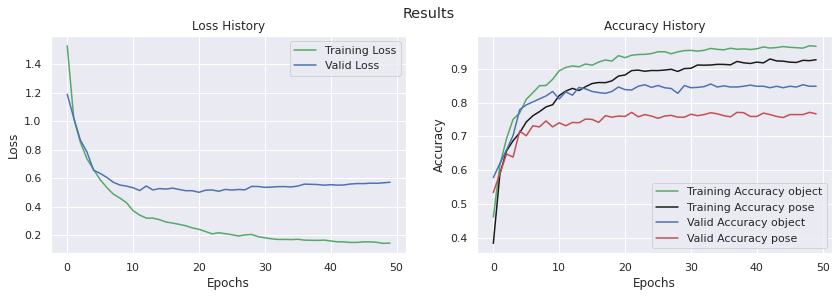

In [19]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 34
with a validation loss of: 0.5404322 and a validation accuracy of: 85.46255230903625


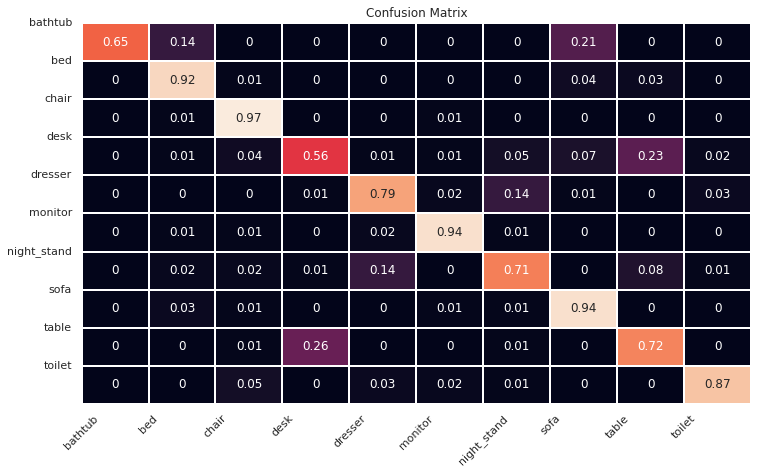

In [20]:
trainer3.generateConfusionMatrix()

best model was trained at epoch: 34
with a validation loss of: 0.5404322 and a validation accuracy of: 85.46255230903625


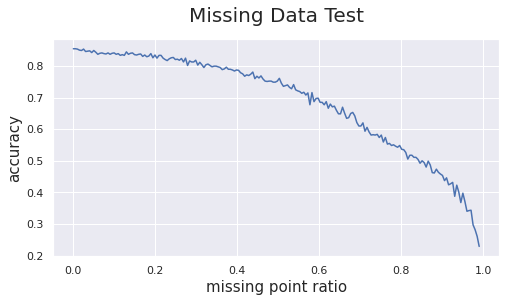

In [24]:
trainer3.missing_data_test()

# VoxNet model comparison

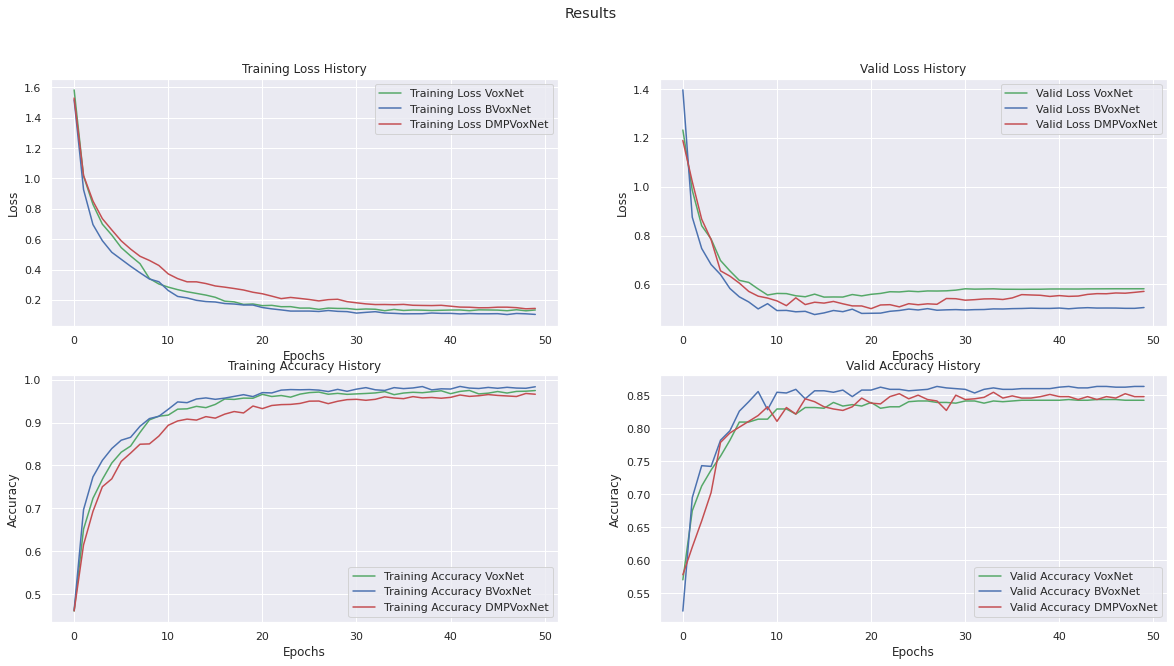

In [21]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [25]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [27]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [28]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [29]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [30]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [31]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [34]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer4 = PointNet_Trainer(training_hyperparameters)
trainer4.train()

model PointNet was chosen
124.71875


Train loss: 0.8409672379493713: : 124it [18:53,  9.14s/it]
15it [03:36, 14.41s/it]


epoch:  1 / 20
time: 1350.00 seconds
train-loss: 1.23, train-acc: 59.15%
valid-loss: 1.00, valid-acc: 65.31%



Train loss: 0.7934558391571045: : 71it [10:54,  7.68s/it]

# Download and unzip the dataset ModelNet40



In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-02-04 20:40:31--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-02-04 20:40:31--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  60.7MB/s    in 52s     

2023-02-04 20:41:23 (37.4 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

In [ ]:
ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


  0%|          | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

# DMPVoxNet with Modelnet40

In [ ]:
class VoxelDataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      
      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset40(train=True)
      self.test_ds = VoxelDataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      self.model = DMPVoxNet40()
      os.mkdir('/content/'+str(self.name_model))
      print('model DMPVoxNet40 was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=40)
      valid_accuracy = Accuracy(task='multiclass', num_classes=40)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          self.lr_scheduler.step()
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data[0], data[1]
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)

              self.opt.zero_grad()
              pred = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred,labels)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              pred_choice = pred.data.max(1)[1]
              correct = pred_choice.eq(labels.data).cpu().sum()
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test = labels_test.to(self.device)
                inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
                
                pred_test = self.model(inputs_test)
                loss_test = self.loss_fn(pred_test, labels_test)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = pred_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test, 1))
                self.y_conf.append(labels_test)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if epoch>1 and total_valid_accuracy>valid_acc_history[-2]:

              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=40, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,12))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
from collections import OrderedDict
class DMPVoxNet40(nn.Module):
    def __init__(self):
        super(DMPVoxNet40, self).__init__()
        n_classes = 40
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=128, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet40'
}    

trainer5 = VoxNet_Trainer40(training_hyperparameters)
trainer5.train()

In [ ]:
import numpy as np
a = np.array([0.2, 0.3, 0.3])
b = np.array([0.2, 0.2, 0.2])
c = np.array([0.2, 0.2, 0.2])
d = [0, 0, 0]
e = np.array([0, 0, 0])

for i in range(len(c)):
  d[i] = a[i]/3+b[i]/3+c[i]/3

f = np.array([a, b, c])
e = np.einsum('ij->j', f/3)

for i in range(0,2):
  pred_test = []
  print(pred_test)
  labels_test = []

  for k in range(1):
    temp = f
    pred_test.append(np.einsum('ij->j', f/3))
  print(pred_test)


[]
[array([0.2       , 0.23333333, 0.23333333])]
[]
[array([0.2       , 0.23333333, 0.23333333])]
